Imports

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from scipy.spatial import KDTree

Einlesen CSV-Datei

In [148]:
df = pd.read_csv('telco_churn.csv', index_col=0, sep = ';')
df.drop(columns = 'Count', inplace = True)
df.head()

,Country,State,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Score,CLTV
CustomerID,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,United States,California,NaN,NaN,"33,964131","-118,272783",Male,No,No,No,...,No,No,No,Month-to-month,Yes,Mailed check,"53,85","108,15",86.0,3239.0
9237-HQITU,United States,California,Los Angeles,90005.0,"34,059281","-118,307420",Female,No,No,Yes,...,No,NaN,No,Month-to-month,Yes,Electronic check,"70,7","151,65",NaN,2701.0
9305-CDSKC,United States,California,Los Angeles,90006.0,"34,048013","-118,293953",Female,No,No,Yes,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,"99,65","820,5",86.0,5372.0
7892-POOKP,United States,California,Los Angeles,90010.0,"34,062125","-118,315709",Female,No,Yes,Yes,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,"104,8","3046,05",84.0,5003.0
0280-XJGEX,United States,California,Los Angeles,90015.0,"34,039224","-118,266293",Male,No,No,Yes,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),"103,7","5036,3",89.0,NaN


Datentyp zu 'Categorical' geändert, wenn angebracht.
Zip Code, Tenure Months, Monthly Charges und Total Charges zu 'Float' geändert, um die Verarbeitung zu erleichtern.
Latitude und Longitude bleiben 'Object', da 'Integer' oder 'Float' hier nicht weiterhilft.

In [149]:
df.Country = df.Country.astype('category')
df.State = df.State.astype('category')
df.City = df.City.astype('category')
cols = []
for i in range(6,23):
    cols.append(df.columns[i]) # Zunächst alle Spalten zu Category, da Großteil so bleibt. Tenure Months wird separat geändert
    for col in cols:
        df[col] = df[col].astype('category')
df['Monthly Charges'] = df['Monthly Charges'].str.replace(',','.').str.replace(' ','').astype('float64') # Kommata werden durch Punkt ersetzt, damit Umwandlung in Float funktioniert
df['Total Charges'] = df['Total Charges'].str.replace(',','.').str.replace(' ','0').astype('float64')    # Kommata werden durch Punkt ersetzt, damit Umwandlung in Float funktioniert
df.Latitude = df.Latitude.str.replace(',','.').astype('object')
df.Longitude = df.Longitude.str.replace(',','.').astype('object')

df['Tenure Months'] = df['Tenure Months'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Country            7043 non-null   category
 1   State              6001 non-null   category
 2   City               6237 non-null   category
 3   Zip Code           5986 non-null   float64 
 4   Latitude           6081 non-null   object  
 5   Longitude          6390 non-null   object  
 6   Gender             7043 non-null   category
 7   Senior Citizen     7043 non-null   category
 8   Partner            7043 non-null   category
 9   Dependents         7043 non-null   category
 10  Tenure Months      5900 non-null   float64 
 11  Phone Service      7043 non-null   category
 12  Multiple Lines     7043 non-null   category
 13  Internet Service   6313 non-null   category
 14  Online Security    7043 non-null   category
 15  Online Backup      7043 non-null   category
 

Visualisierung der relevanten Variablen.

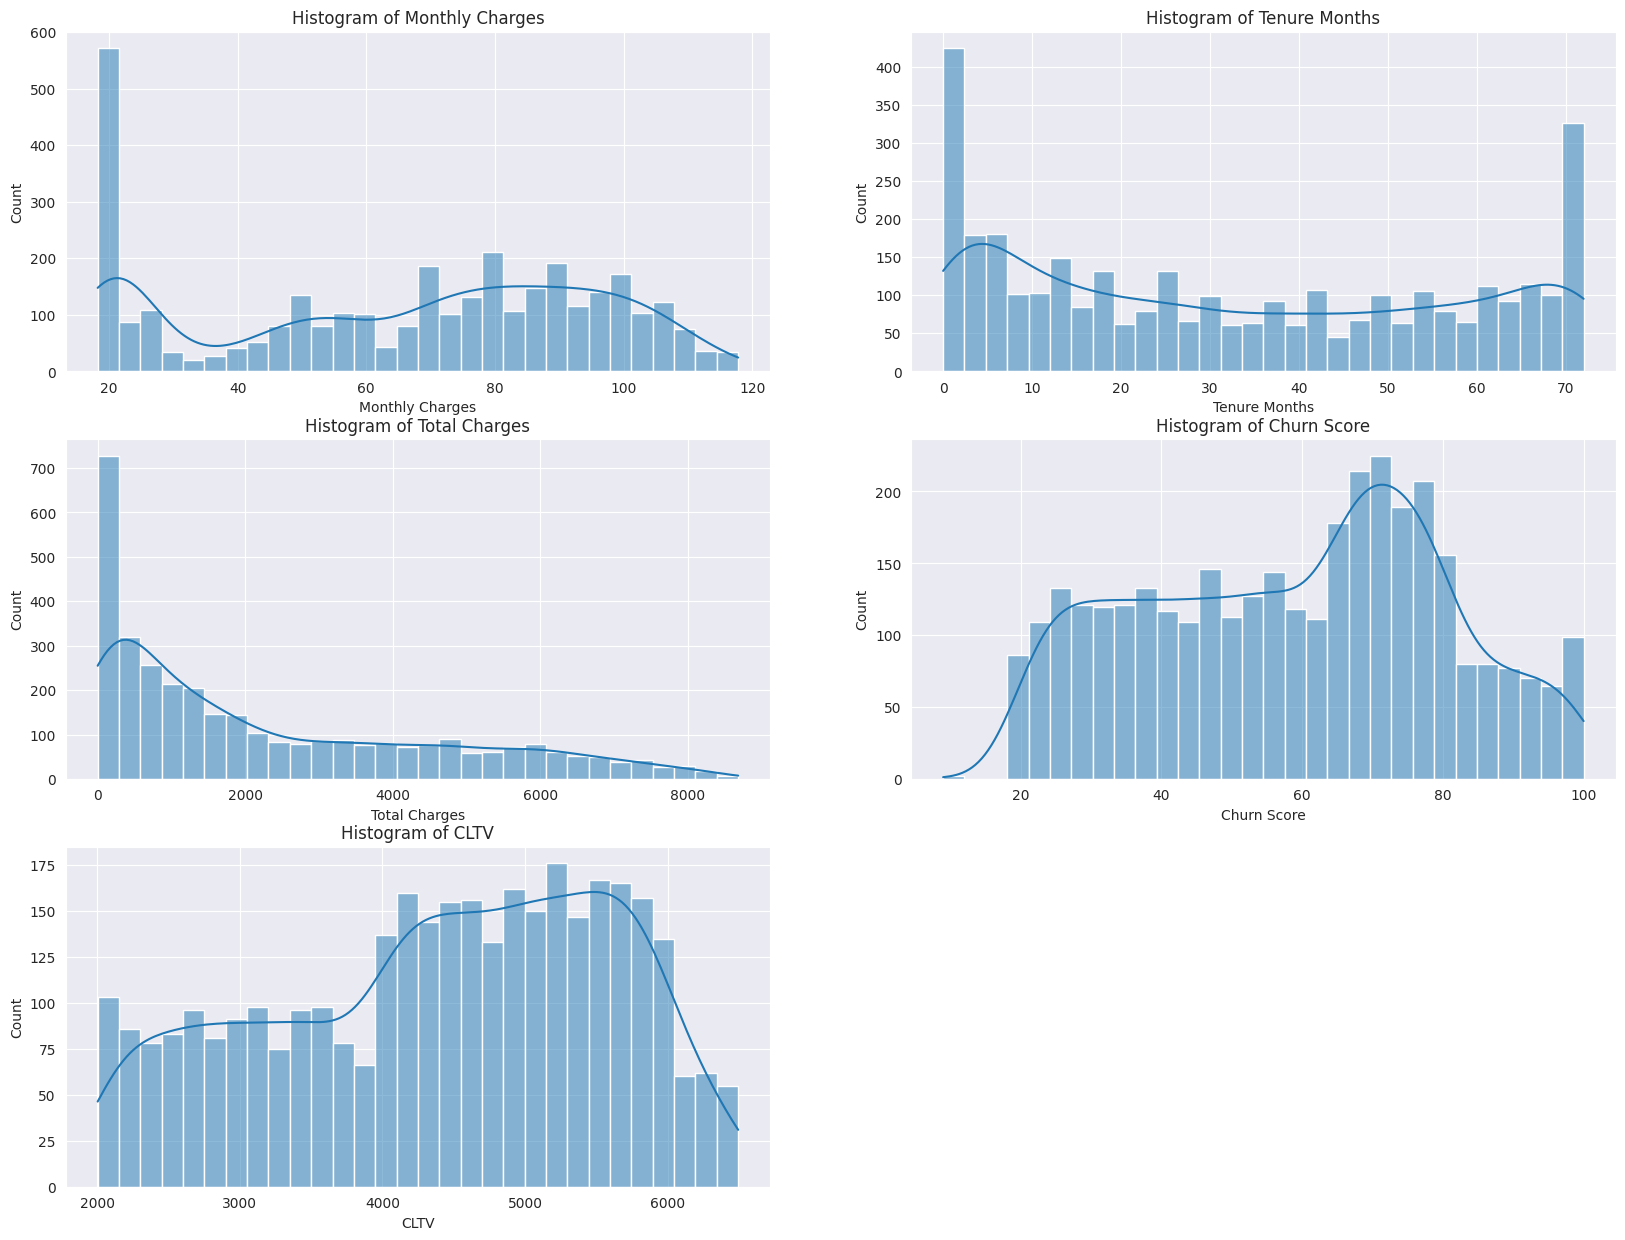

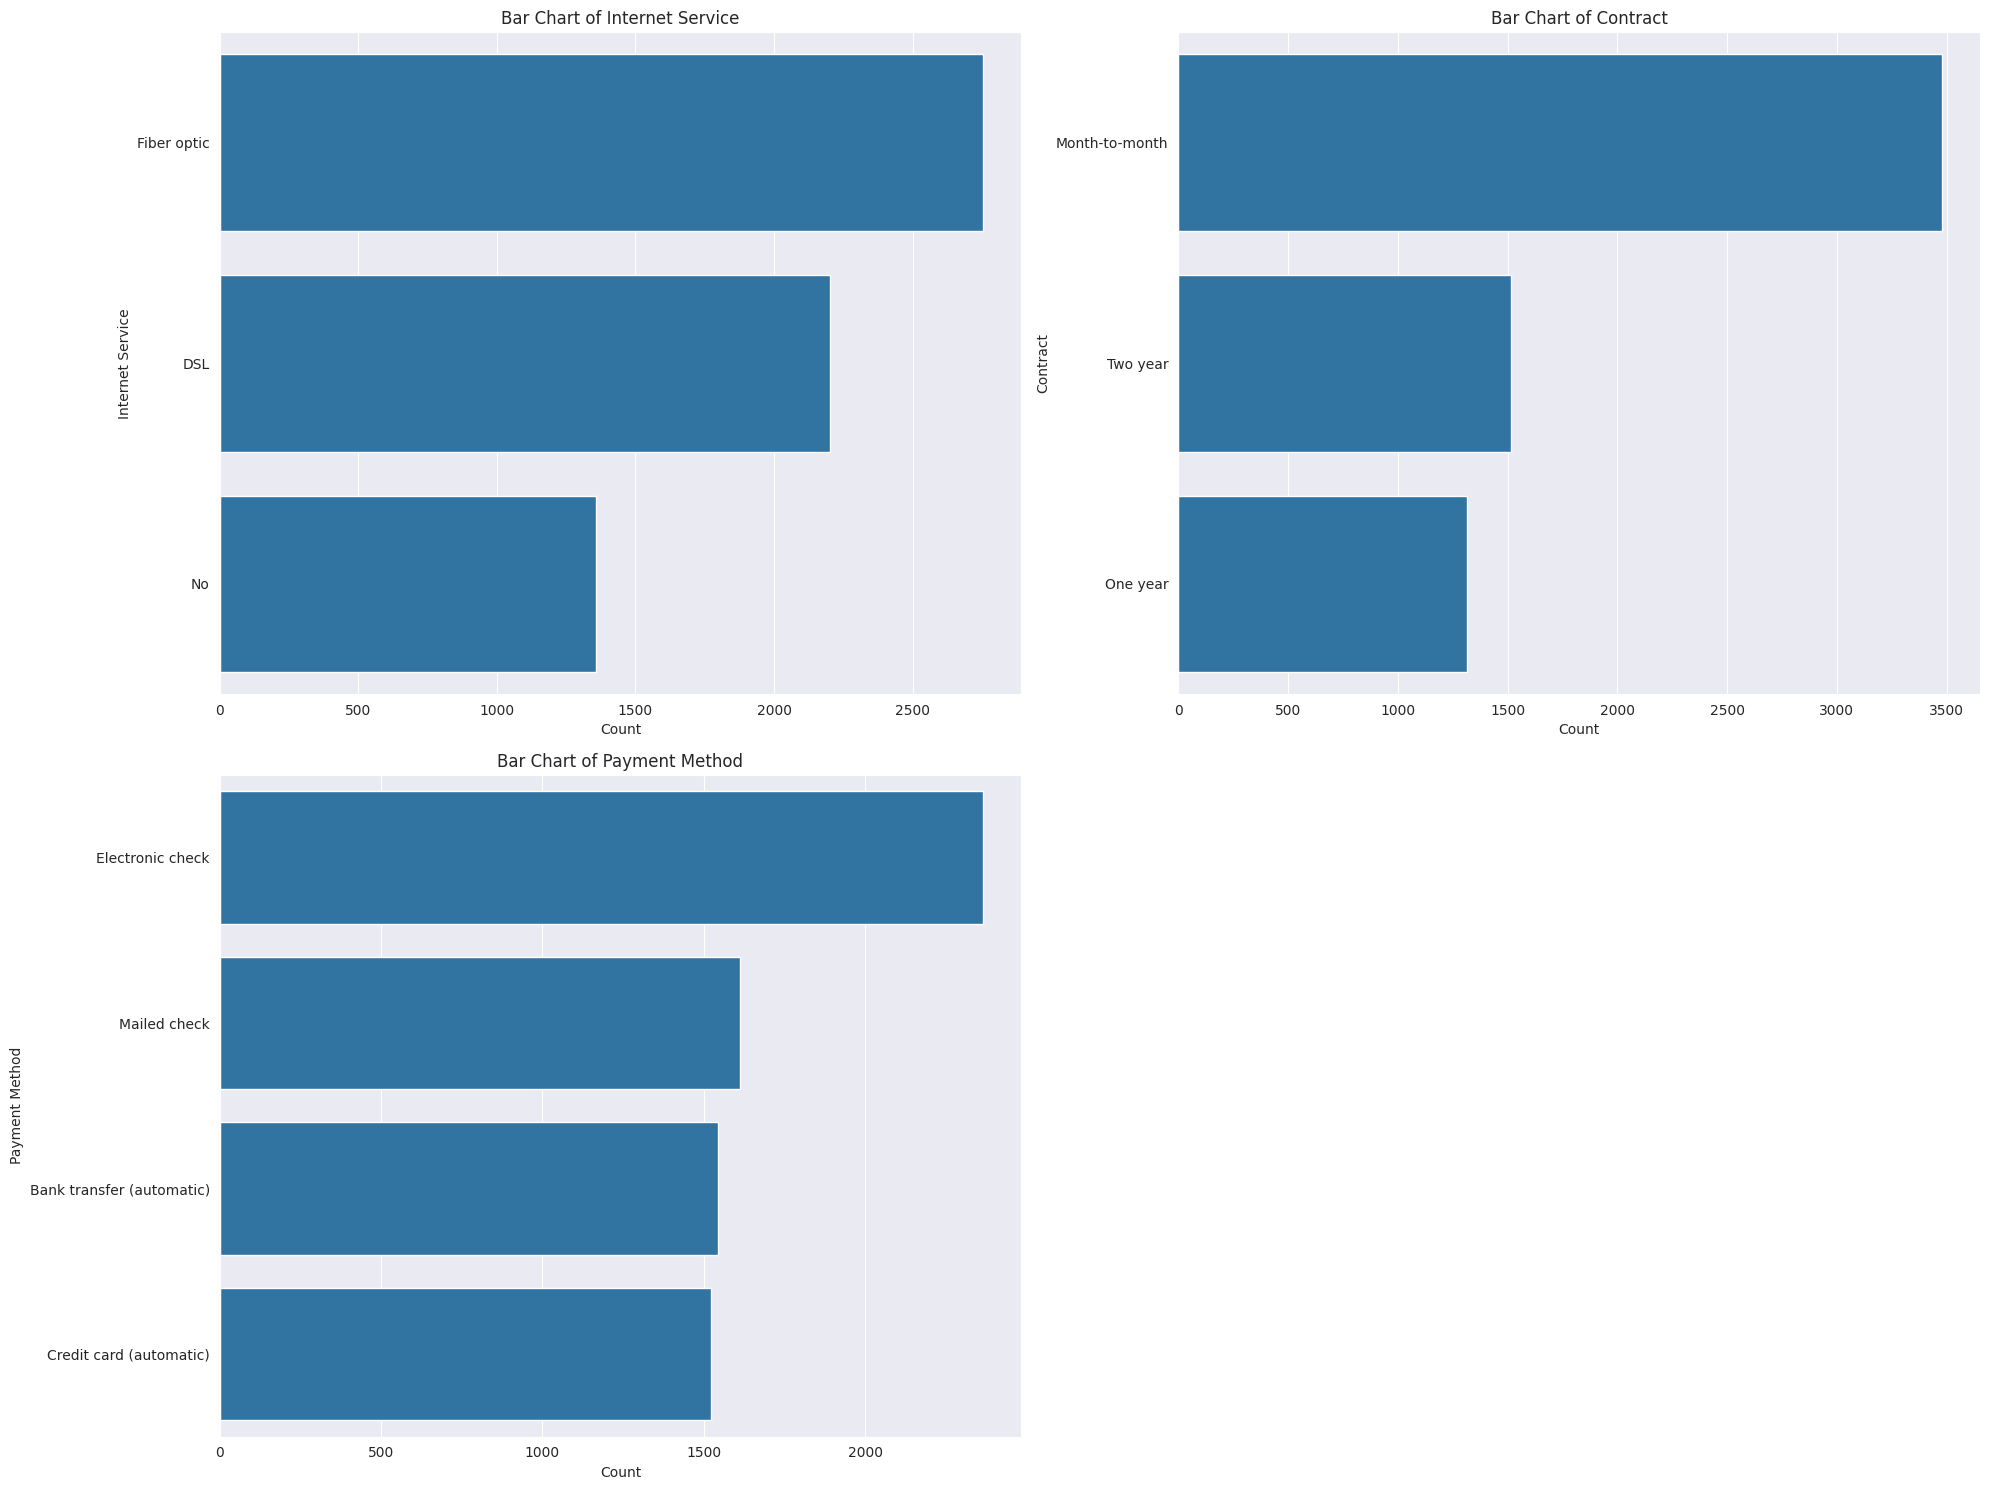

In [150]:

## NaN wird für Visualisierung entfernt
df_cleaned = df.dropna(subset=['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Score', 'CLTV'])

# Histogramme für alle Float-Spalten
columns_to_plot = ['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Score', 'CLTV']

plt.figure(figsize=(20, 15)) # Größe des gesamten Plots

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)  # 3 Reihen und 2 Spalten für Subplots
    sb.histplot(df_cleaned[column], bins=30, kde=True) # 30 Bins hat sich als guter Wert herausgestellt
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

## Barcharts für "interessante" Werte
features_to_bar_chart = ['Internet Service', 'Contract', 'Payment Method']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(features_to_bar_chart, 1):
    plt.subplot(2, 2, i)  # 2 Reihen und 2 Spalten für Subplots
    sb.countplot(y=feature, data=df, order=df[feature].value_counts().index)
    plt.title(f'Bar Chart of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)

# Layout anpassen
plt.tight_layout()
plt.show()


1b) Korrelationsmatrix

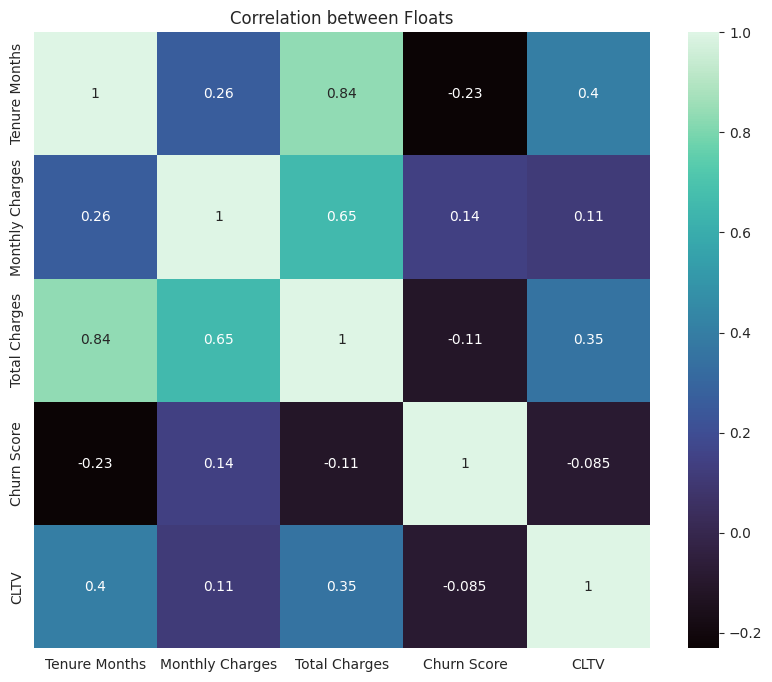

In [151]:
float_columns = df[['Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Score', 'CLTV']]
plt.figure(figsize=(10, 8))
sb.heatmap(float_columns.corr(), annot= True, cmap='mako', square=True)
plt.title('Correlation between Floats')
plt.show()


Aufgabe 2

In [152]:
## Drop Country und State, da immer gleich und somit keine Aussage

if 'Country' in df.columns:
    df.drop('Country', axis = 1, inplace = True)
if 'State' in df.columns:
    df.drop('State', axis = 1, inplace = True)
df.dropna(subset= ['Churn Score'],inplace=True)

In [153]:
## Fehlende Werte identifizieren
missing_rows = df[(df['City'].isna()) | (df['Zip Code'].isna())]
available_rows = df.dropna(subset=['Zip Code','Latitude','Longitude'])

## Runden für bessere Ergebnisse
df['Latitude'] = df['Latitude'].round(3)
df['Longitude'] = df['Longitude'].round(3)


## KDTree für schnelle nächstgelegene Nachbarn-Suche
tree = KDTree(available_rows[['Latitude', 'Longitude']].values)
## Fehlende Werte auffüllen
for index, row in missing_rows.iterrows():
    if not pd.isna(row['Latitude']):
        if not pd.isna(row['Longitude']):
            lat_lon = [row['Latitude'], row['Longitude']]
            dist, nearest_idx = tree.query(lat_lon)  # Nächstgelegene Zeile finden
            nearest_row = available_rows.iloc[nearest_idx]

            if pd.isna(row['Zip Code']):
                df.at[index, 'Zip Code'] = nearest_row['Zip Code']

if 'City' in df.columns:
    df.drop('City', axis=1, inplace=True)
if 'Latitude' in df.columns:
    df.drop('Latitude', axis=1, inplace=True)
if 'Longitude' in df.columns:
    df.drop('Longitude', axis=1, inplace=True)


In [154]:
## Tenure Months = Total Charges / Monthly Charges, wenn beides vorhanden
def calculate_tenure(df):
    for index, row in df.iterrows():
        if pd.isna(row['Tenure Months']) or row['Tenure Months'] == "":
            if pd.notna(row['Monthly Charges']) and pd.notna(row['Total Charges']):
                try:
                    df.at[index, 'Tenure Months'] = round(float(row['Total Charges']) / float(row['Monthly Charges']))
                except (ValueError, ZeroDivisionError):
                    pass  #Fängt fehler ab, insbesondere Teilen durch 0
    return df

## Monthly Charges = Total Charges / Tenure Months, wenn beides vorhanden
def calculate_monthly_charges(df):
    for index, row in df.iterrows():
        if pd.isna(row['Monthly Charges']) or row['Monthly Charges'] == "":
            if pd.notna(row['Total Charges']) and pd.notna(row['Tenure Months']):
                try:
                    df.at[index,'Monthly Charges'] = round(float(row['Total Charges']) / float(row['Tenure Months']),2)
                except (ValueError, ZeroDivisionError):
                    pass  #Fängt fehler ab, insbesondere Teilen durch 0

# Total Charges = Monthly Charges * Tenure Months, wenn beides vorhanden
def calculate_total_charges(df):
    for index, row in df.iterrows():
        if pd.isna(row['Total Charges']) or row['Total Charges'] == "":
            if pd.notna(row['Monthly Charges']) and pd.notna(row['Tenure Months']):
                try:
                    df.at[index,'Total Charges'] = round(float(row['Monthly Charges']) * float(row['Tenure Months']),2)
                except (ValueError, ZeroDivisionError):
                    pass  #Fängt fehler ab, insbesondere Teilen durch 0


calculate_tenure(df)
calculate_monthly_charges(df)
calculate_total_charges(df)

Fix Tenure Months / Charges


In [155]:
## Neuronales Netzwerk wird durch die Korrelation vorhandener Werte von Tenure Months und Total Charges trainiert, um fehlende Tenure Months anhand der Total Charges zu schätzen

df['Tenure Months Train'] = df['Tenure Months']
df['Total Charges Train'] = df['Total Charges']
df.reset_index(drop=True, inplace=True)

imputer = SimpleImputer(strategy='mean')
df['Total Charges Train'] = imputer.fit_transform(df[['Total Charges Train']])

dft = df[['Tenure Months Train','Total Charges Train']].dropna()
dft.columns = dft.columns.str.strip()
x_train = dft[['Total Charges Train']]
y_train = dft[['Tenure Months Train']]

model = LinearRegression()
model.fit(x_train, y_train)

missing_tenure = df['Tenure Months'].isnull()

X_missing = df.loc[missing_tenure, ['Total Charges Train']]
df.loc[missing_tenure, 'Tenure Months'] = model.predict(X_missing).round()
df.drop(columns=['Total Charges Train','Tenure Months Train'], inplace=True)




In [156]:
## Erneutes füllen von Monthly Charges und Total Charges, um Fehler durch neuronales Netzwerk zu minimieren

calculate_monthly_charges(df)
calculate_total_charges(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Zip Code           5953 non-null   float64 
 1   Gender             6137 non-null   category
 2   Senior Citizen     6137 non-null   category
 3   Partner            6137 non-null   category
 4   Dependents         6137 non-null   category
 5   Tenure Months      6137 non-null   float64 
 6   Phone Service      6137 non-null   category
 7   Multiple Lines     6137 non-null   category
 8   Internet Service   5493 non-null   category
 9   Online Security    6137 non-null   category
 10  Online Backup      6137 non-null   category
 11  Device Protection  5127 non-null   category
 12  Tech Support       6137 non-null   category
 13  Streaming TV       5117 non-null   category
 14  Streaming Movies   6137 non-null   category
 15  Contract           5494 non-null   category
 16  Paperl

Use Total Charges / Tenure Months to calculate Missing Monthly Charges and Tenure Months * Monthly Charges to calculate missing Total Charges


In [157]:
## Neuronales Netzwerk wird durch die Korrelation vorhandener Werte von Tenure Months und Monthly Charges trainiert, um fehlende Monthly Charges anhand der Tenure Months zu schätzen

df['Tenure Months'] = pd.to_numeric(df['Tenure Months'], errors='coerce')
df['Monthly Charges'] = pd.to_numeric(df['Monthly Charges'], errors='coerce')

train_df = df.dropna(subset=['Monthly Charges'])

X_train = train_df[['Tenure Months']]
y_train = train_df['Monthly Charges']

model = LinearRegression()
model.fit(X_train, y_train)

missing_mask = df['Monthly Charges'].isna()
df.loc[missing_mask, 'Monthly Charges'] = model.predict(df.loc[missing_mask, ['Tenure Months']]).round(2)

## Auffüllen der letzten fehlenden Total Charges, da Tenure Months und Monthly Charges nun vollständig

calculate_total_charges(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Zip Code           5953 non-null   float64 
 1   Gender             6137 non-null   category
 2   Senior Citizen     6137 non-null   category
 3   Partner            6137 non-null   category
 4   Dependents         6137 non-null   category
 5   Tenure Months      6137 non-null   float64 
 6   Phone Service      6137 non-null   category
 7   Multiple Lines     6137 non-null   category
 8   Internet Service   5493 non-null   category
 9   Online Security    6137 non-null   category
 10  Online Backup      6137 non-null   category
 11  Device Protection  5127 non-null   category
 12  Tech Support       6137 non-null   category
 13  Streaming TV       5117 non-null   category
 14  Streaming Movies   6137 non-null   category
 15  Contract           5494 non-null   category
 16  Paperl

Internet Service

<Axes: >

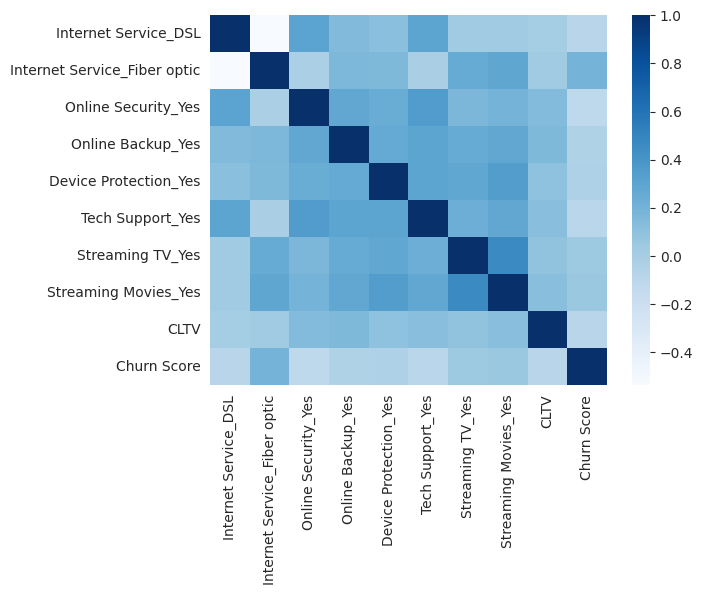

In [166]:
## Korrelationsmatrix aller Werte im Zusammenhang mit Internet Service. Es werden nur 'Yes'-Werte betrachtet, da 'No internet service' hierfür irrelevant und 'No' immer das Gegenteil von 'Yes' ist.

categorical_columns = ['Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']
categorical_columns = [col for col in categorical_columns if col in df.columns]
df_encoded = pd.get_dummies(df, columns=['Internet Service'], drop_first=False)
df_encoded = pd.get_dummies(df_encoded, columns=[col for col in categorical_columns if col != 'Internet Service'], drop_first=True)
relevant_columns = [col for col in df_encoded.columns if any(cat in col for cat in categorical_columns) and '_No' not in col]
relevant_columns.append('CLTV')
relevant_columns.append('Churn Score')
df_encoded = df_encoded[relevant_columns]

correlation_matrix = df_encoded.corr(numeric_only=True)
sb.heatmap(correlation_matrix, cmap="Blues", annot=False)

In [164]:
## Immer, wenn eine Spalte 'No internet Service' enthält, wird Internet Service auf 'No' gesetzt und der Rest der Zeile auf 'No internet service'

internet_service_col = "Internet Service"
target_columns = ["Online Security", "Online Backup", "Device Protection",
                  "Tech Support", "Streaming TV", "Streaming Movies"]

mask = df[target_columns].eq("No internet service").any(axis=1)
df.loc[mask, target_columns] = "No internet service"
df.loc[mask, internet_service_col] = "No"

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Zip Code           5953 non-null   float64 
 1   Gender             6137 non-null   category
 2   Senior Citizen     6137 non-null   category
 3   Partner            6137 non-null   category
 4   Dependents         6137 non-null   category
 5   Tenure Months      6137 non-null   float64 
 6   Phone Service      6137 non-null   category
 7   Multiple Lines     6137 non-null   category
 8   Internet Service   5645 non-null   category
 9   Online Security    6137 non-null   category
 10  Online Backup      6137 non-null   category
 11  Device Protection  5349 non-null   category
 12  Tech Support       6137 non-null   category
 13  Streaming TV       5330 non-null   category
 14  Streaming Movies   6137 non-null   category
 15  Contract           5494 non-null   category
 16  Paperl

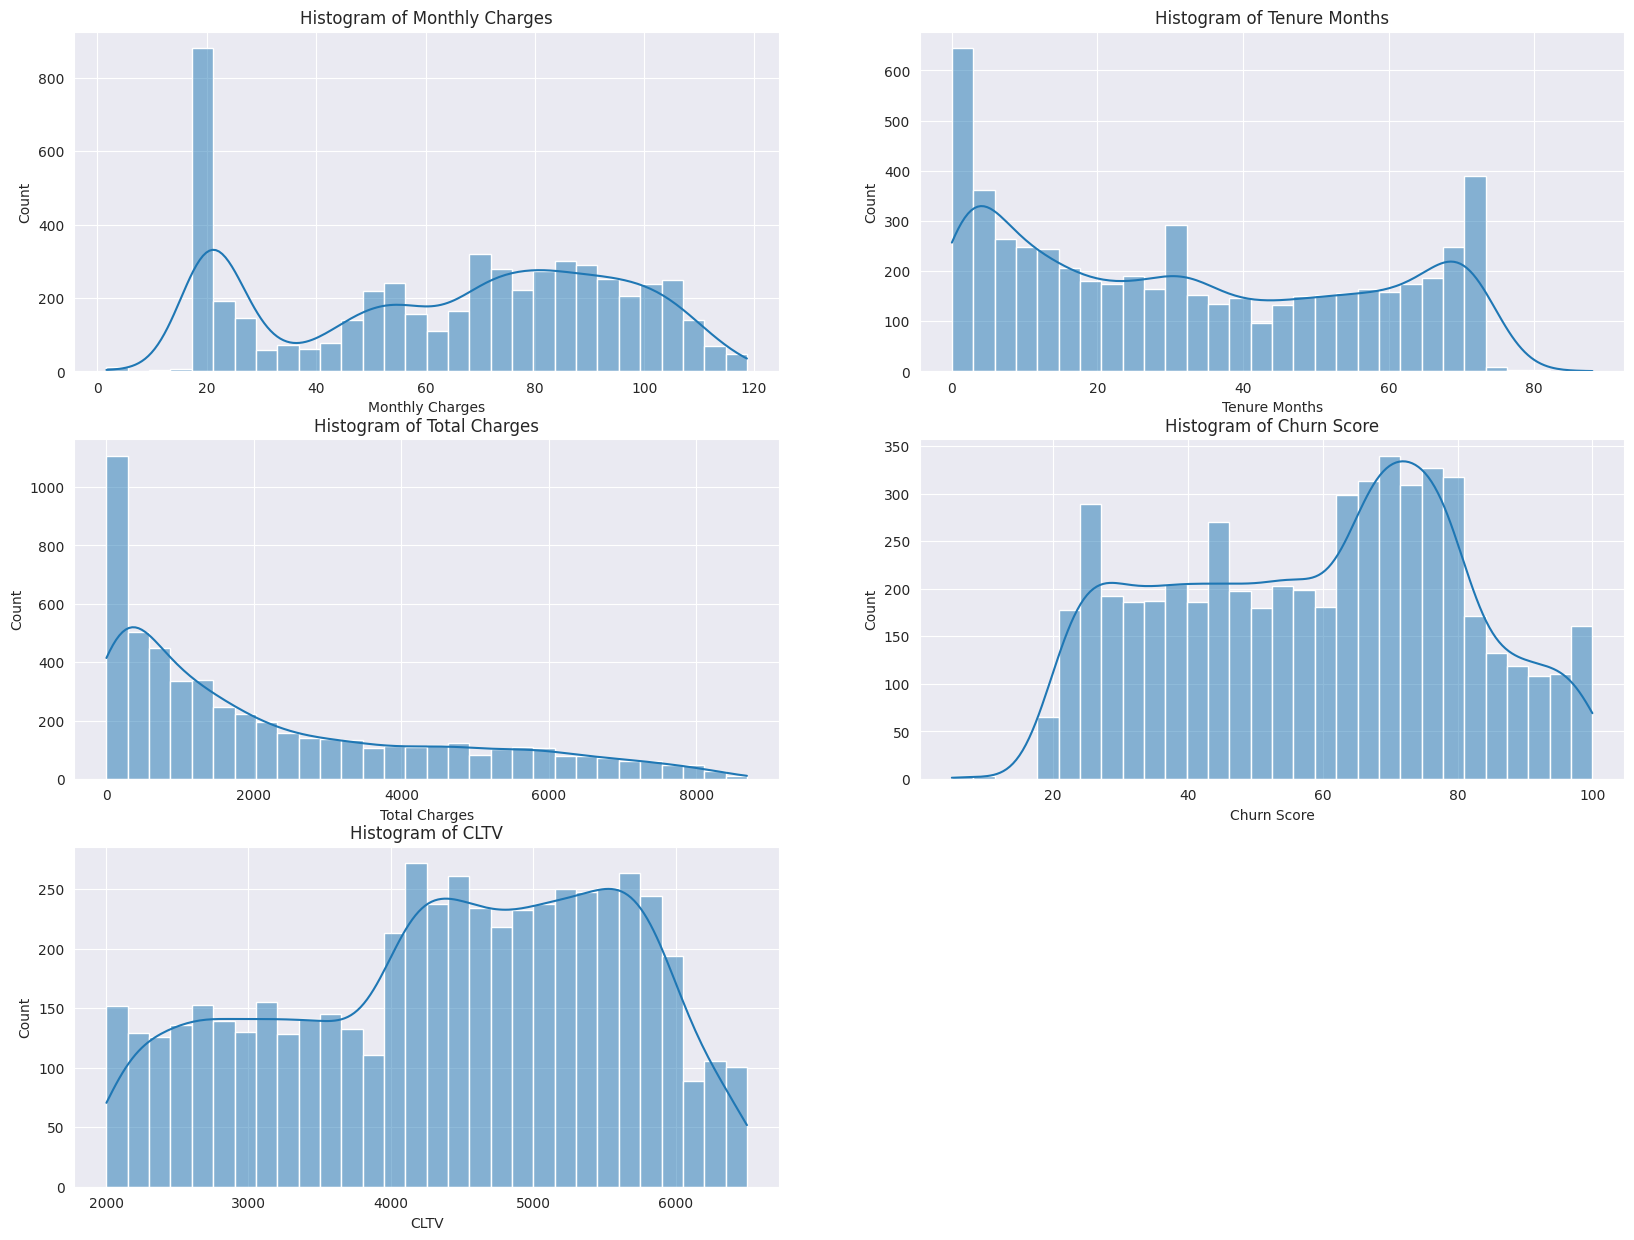

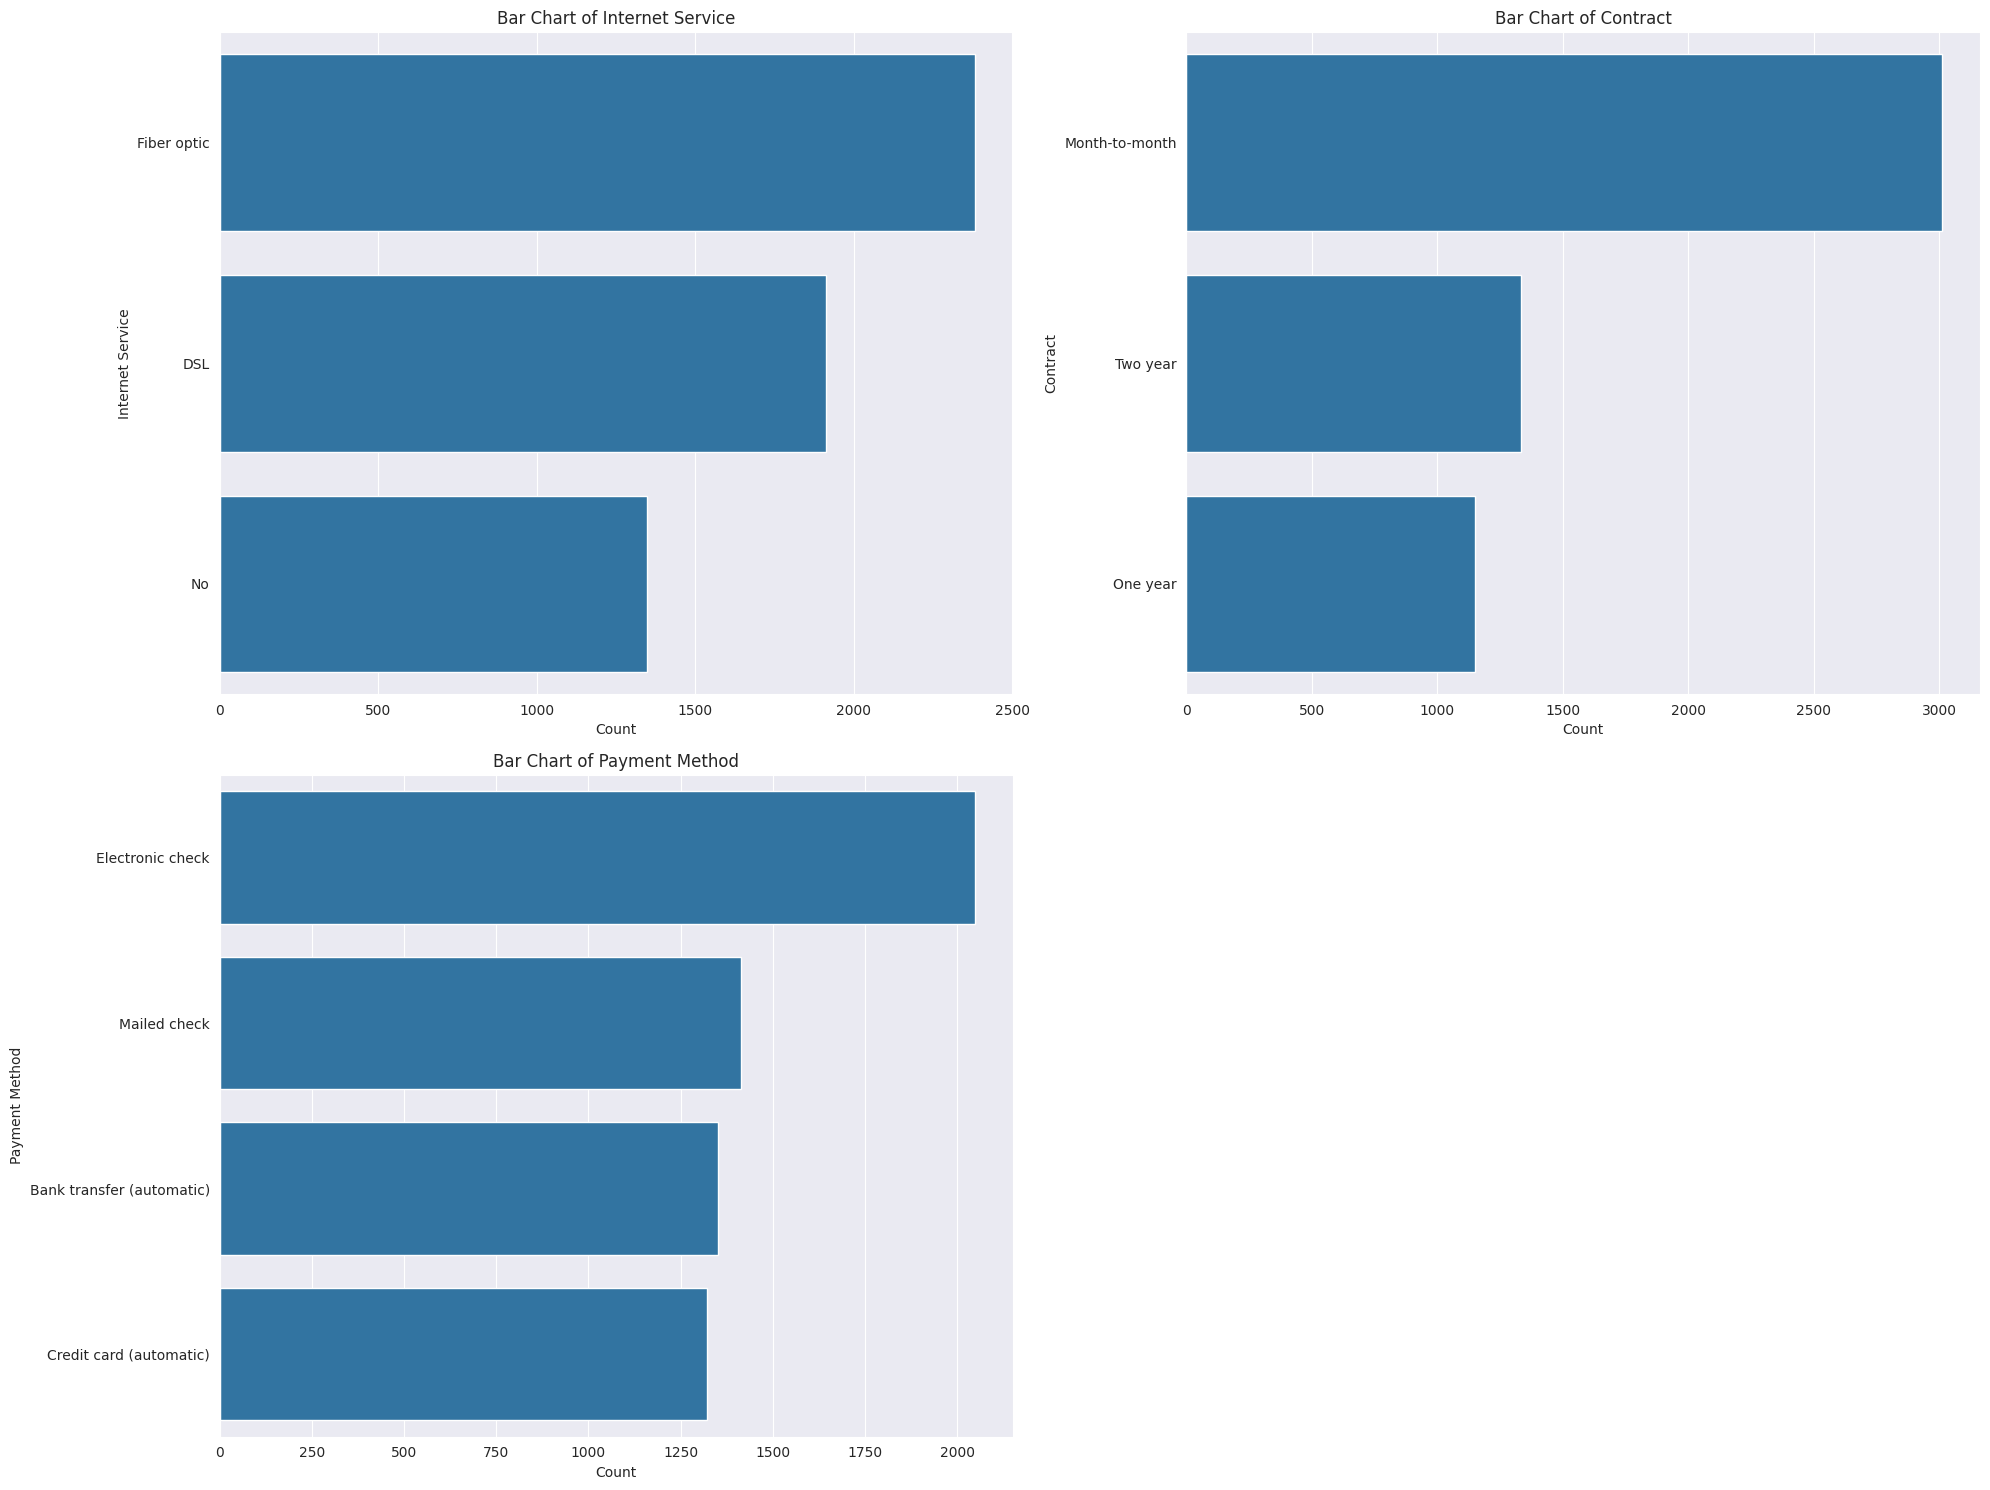

In [165]:
### Erneutes erzeugen der Charts. Code identisch, um so 1:1 Vergleich zu erstellen


## NaN wird für Visualisierung entfernt
df_cleaned = df.dropna(subset=['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Score', 'CLTV'])

# Histogramme für alle Float-Spalten
columns_to_plot = ['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Score', 'CLTV']

plt.figure(figsize=(20, 15)) # Größe des gesamten Plots

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)  # 3 Reihen und 2 Spalten für Subplots
    sb.histplot(df_cleaned[column], bins=30, kde=True) # 30 Bins hat sich als guter Wert herausgestellt
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

## Barcharts für "interessante" Werte
features_to_bar_chart = ['Internet Service', 'Contract', 'Payment Method']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(features_to_bar_chart, 1):
    plt.subplot(2, 2, i)  # 2 Reihen und 2 Spalten für Subplots
    sb.countplot(y=feature, data=df, order=df[feature].value_counts().index)
    plt.title(f'Bar Chart of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)

# Layout anpassen
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Zip Code           5953 non-null   float64 
 1   Gender             6137 non-null   category
 2   Senior Citizen     6137 non-null   category
 3   Partner            6137 non-null   category
 4   Dependents         6137 non-null   category
 5   Tenure Months      6137 non-null   float64 
 6   Phone Service      6137 non-null   category
 7   Multiple Lines     6137 non-null   category
 8   Internet Service   5645 non-null   category
 9   Online Security    6137 non-null   category
 10  Online Backup      6137 non-null   category
 11  Device Protection  5349 non-null   category
 12  Tech Support       6137 non-null   category
 13  Streaming TV       5330 non-null   category
 14  Streaming Movies   6137 non-null   category
 15  Contract           5494 non-null   category
 16  Paperl

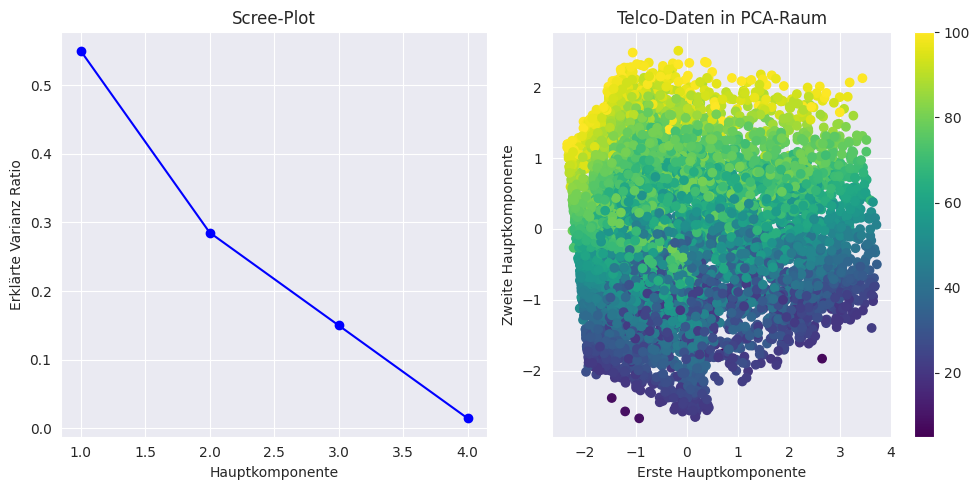

Erklärte Varianz Ratio: [0.55007597 0.28527341 0.15002061 0.01463001]
Gesamte erklärte Varianz: 100.00%


In [161]:

def meine_pca(X, n_components):

    X_centered = X - np.mean(X, axis=0)

    n_samples = X.shape[0]
    covariance_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)

    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    top_eigenvectors = eigenvectors[:, :n_components]

    transformed_data = np.dot(X_centered, top_eigenvectors)

    explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)

    return transformed_data, explained_variance_ratio


from sklearn.preprocessing import StandardScaler


selected_columns = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Score']
df_selected = df[selected_columns].copy()
df_selected.dropna(inplace=True)
df.info()
def test_pca_implementation():
    # Zentriere und skaliere die Daten
    if df_selected.shape[0] > 0:  # Verhindert, dass leere Daten weiterverarbeitet werden
        scaler = StandardScaler()
        X = scaler.fit_transform(df_selected)
    else:
        raise ValueError("Alle Zeilen wurden entfernt. Prüfe deine Daten auf NaN oder nicht-numerische Werte.")


    # Wähle die Anzahl der Hauptkomponenten
    n_components = 4

    # Durchführen der PCA
    transformed_data, explained_variance_ratio = meine_pca(X, n_components)

    plt.figure(figsize=(10, 5))

    # Plot 1: Scree-Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(explained_variance_ratio) + 1),
             explained_variance_ratio, 'bo-')
    plt.xlabel('Hauptkomponente')
    plt.ylabel('Erklärte Varianz Ratio')
    plt.title('Scree-Plot')

    # Plot 2: Transformierte Daten
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1],
                         c=df['Churn Score'], cmap='viridis')

    plt.xlabel('Erste Hauptkomponente')
    plt.ylabel('Zweite Hauptkomponente')
    plt.title('Telco-Daten in PCA-Raum')
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

    # Drucke die erklärte Varianz
    print("Erklärte Varianz Ratio:", explained_variance_ratio)
    print("Gesamte erklärte Varianz: {:.2f}%".format(
        np.sum(explained_variance_ratio) * 100))

test_pca_implementation()

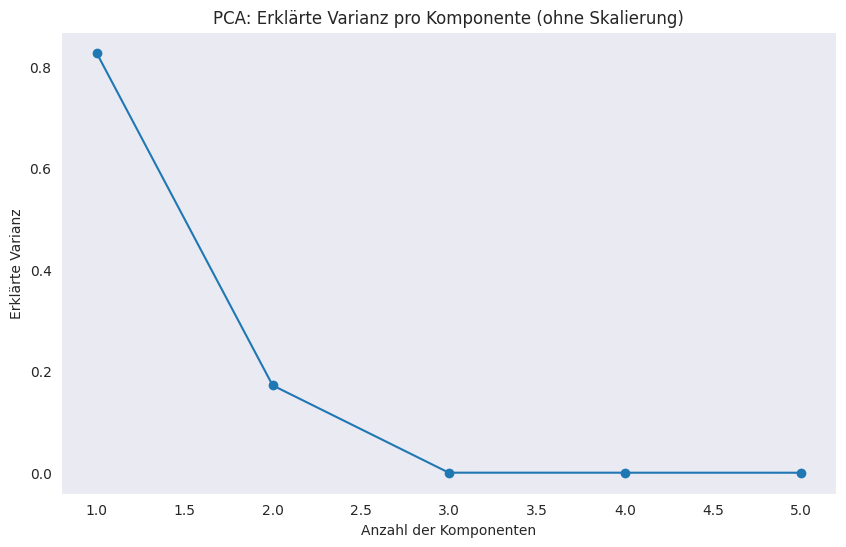

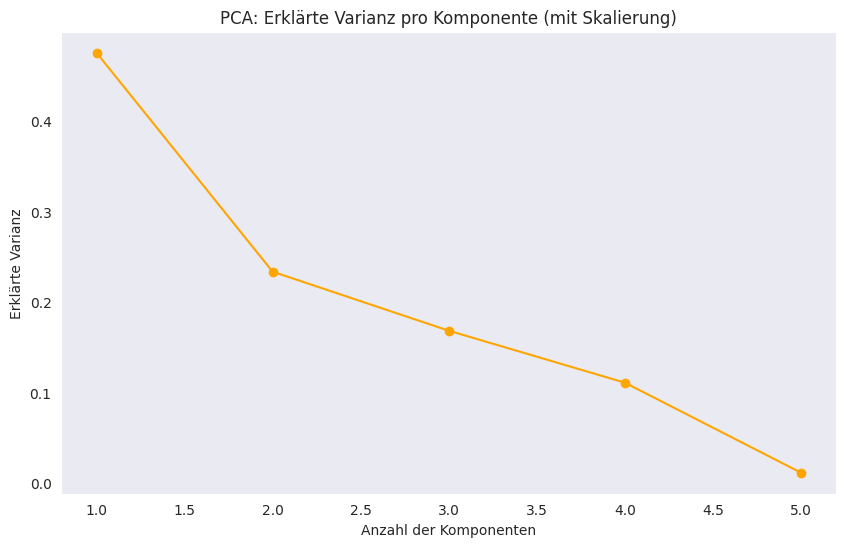

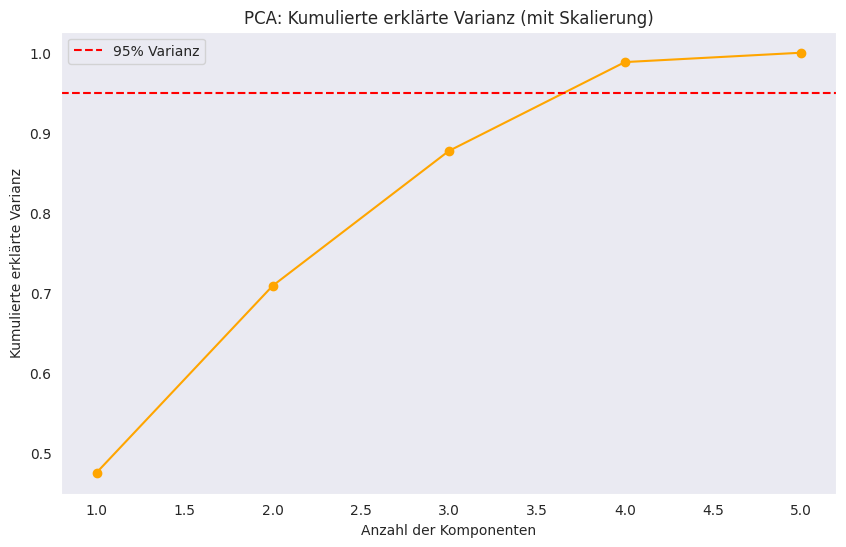

In [162]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Nur numerische Spalten auswählen
numerical_columns = ["CLTV","Churn Score", "Total Charges", "Monthly Charges","Tenure Months"]
df_numeric = df[numerical_columns]

# Fehlende Werte mit dem Median ersetzen, da PCA NaN nicht zulässt
df_numeric = df_numeric.fillna(df_numeric.median())

# (a) PCA ohne Skalierung
pca = PCA()
pca.fit(df_numeric)

# Erklärte Varianz berechnen
explained_variance = pca.explained_variance_ratio_

# Plot der erklärten Varianz pro Komponente
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="-")
plt.xlabel("Anzahl der Komponenten")
plt.ylabel("Erklärte Varianz")
plt.title("PCA: Erklärte Varianz pro Komponente (ohne Skalierung)")
plt.grid()
plt.show()

# Standardisierung der numerischen Variablen
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# PCA mit skalierten Daten
pca_scaled = PCA()
pca_scaled.fit(df_scaled)

# Erklärte Varianz pro Hauptkomponente
explained_variance_scaled = pca_scaled.explained_variance_ratio_

# Plot der erklärten Varianz pro Komponente (mit Skalierung)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_scaled) + 1), explained_variance_scaled, marker="o", linestyle="-", color="orange")
plt.xlabel("Anzahl der Komponenten")
plt.ylabel("Erklärte Varianz")
plt.title("PCA: Erklärte Varianz pro Komponente (mit Skalierung)")
plt.grid()
plt.show()

# Kumulierte erklärte Varianz (mit Skalierung)
cumulative_variance_scaled = np.cumsum(explained_variance_scaled)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_scaled) + 1), cumulative_variance_scaled, marker="o", linestyle="-", color="orange")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Varianz")
plt.xlabel("Anzahl der Komponenten")
plt.ylabel("Kumulierte erklärte Varianz")
plt.title("PCA: Kumulierte erklärte Varianz (mit Skalierung)")
plt.legend()
plt.grid()
plt.show()

